## Chosen Task: Random Circuit Generation

### 0. Task Specification

Design a function that generates a random quantum circuit by considering as parameters the number of qubits, the number of depths, and the base of gates to be used. You could only use the quantum gates of 1 and 2 qubits.

`def random_circuit (int:num_qubits, int:depth, list:basis_gates):`
   
- num_qubits : integer value that is the number of qubits.
- depth: integer value that is the depth for the random circuit.
- basis_gates : A list that contains the basis gates to generate the quantum circuit.
-Return the quantum circuit

The goal of the notebook is to implement the following steps to generate a quantum circuit:
1. Generate a random diagram in the ZX calculus using PyZX.
2. Export the ZX circuit in the QASM format and load as a Qiskit circuit.
3. Convert the Qiskit circuit into a Perceval linear optics circuit.

The reasons for these choices will be explained at the end of notebook.

### 1. Generate a random circuit in the ZX calculus using PyZX


First, install pyzx with `pip install pyzx` and do a basic test by using the built in circuit generation method.

In [3]:
import pyzx as zx

circuit = zx.generate.CNOT_HAD_PHASE_circuit(qubits=4,depth=20,clifford=True)

In [4]:
zx.draw(circuit)

Next, define the function that generates random ZX diagrams/circuits.  It takes as input the number of qubits `n_qubits`, the depth of the circuit `depth` and a list of gate names `basis_gates`.  For each layer of the circuit, select a random integer number between 1-n_qubits^2. This specifies the number of gates to select per layer.  For each gate selected either (i) select a random qubit and apply a one qubit gate to it or (ii) select two random qubits and apply a two qubit gate. Finally, return the circuit.

For this first implementation we assume that the only two qubit gates are CNOT gates.

In [33]:
def generate_random_zx_circuit(n_qubits,depth,basis_gates):
    
    c = zx.Circuit(qubit_amount=n_qubits)
    
    for i in range(depth):
        for j in range(np.random.randint(n_qubits*2)):
            gate = np.random.choice(basis_gates)
            if gate == "CNOT":
                qubits = np.random.choice(list(range(n_qubits)),size=2,replace=False)
                c.add_gate(gate,qubits[0],qubits[1])
            else:
                qubit = np.random.choice(list(range(n_qubits)))
                c.add_gate(gate,qubit)
                
    return c
    
    

Test the function with a list of gates and a choice of `n_qubits` and `depth`.

In [83]:
basis_gates = ["H","T","S","CNOT"]


c = generate_random_zx_circuit(n_qubits=3,depth=5,basis_gates=basis_gates)

zx.draw(c)

### 2. Export the ZX circuit in the QASM format and load as a Qiskit circuit.

Make sure qiskit is installed `pip install qiskit`.

Every circuit in PyZX has a method `to_qasm` which translates the circuit into a QASM string.  This QASM string can be loaded as a Qiskit circuit.

In [84]:
import qiskit

qasm = c.to_qasm()
qiskit_circuit = qiskit.circuit.QuantumCircuit.from_qasm_str(qasm)
qiskit_circuit.draw()

┌───┐     ┌───┐     
q_0: ──────────────────────■──┤ T ├──■──┤ T ├─────
     ┌───┐┌───┐┌───┐┌───┐  │  ├───┤  │  ├───┤┌───┐
q_1: ┤ T ├┤ S ├┤ X ├┤ X ├──┼──┤ H ├──┼──┤ X ├┤ X ├
     └───┘└───┘└─┬─┘└─┬─┘┌─┴─┐├───┤┌─┴─┐└─┬─┘└─┬─┘
q_2: ────────────■────■──┤ X ├┤ S ├┤ X ├──■────■──
                         └───┘└───┘└───┘

### 3. Convert the Qiskit circuit into a Perceval linear optics circuit.

Install Perceval `pip install perceval`.

In [85]:
import perceval as pcvl
import sympy as sp
import numpy as np

from perceval.components import catalog
from perceval.converters import QiskitConverter

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector



Finally, the linear optical computing framework Perceval has built in  methods for loading a Qiskit circuit.


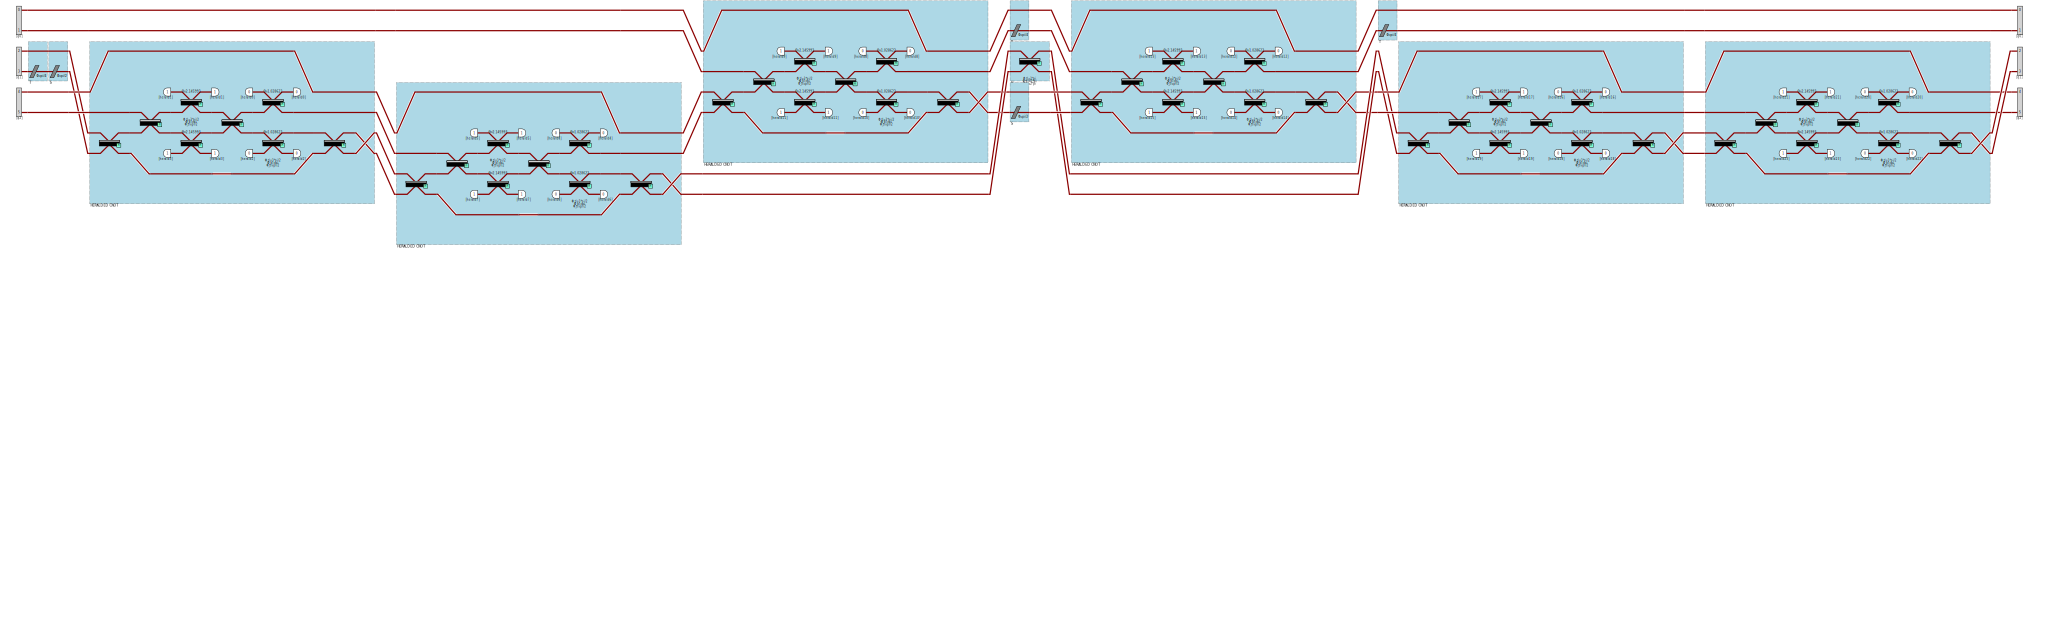

In [87]:


qiskit_converter = QiskitConverter(catalog, backend_name="Naive")
quantum_processor = qiskit_converter.convert(qiskit_circuit, use_postselection=False)
quantum_processor.clear_postprocess()
pcvl.pdisplay(quantum_processor, recursive=True)



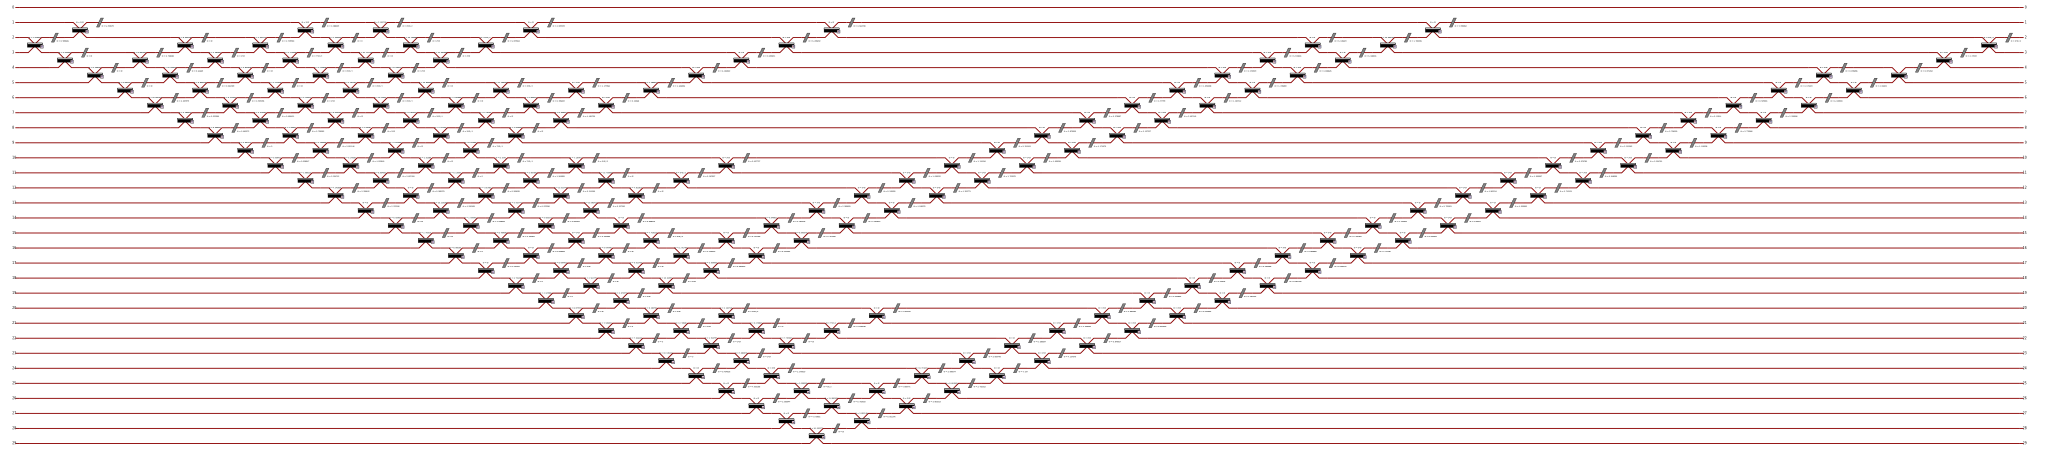

In [88]:
u = quantum_processor.linear_circuit().compute_unitary(use_symbolic=False)

ub = (pcvl.Circuit(2)
      // pcvl.BS(theta=pcvl.Parameter("theta"))
      // (0, pcvl.PS(phi=pcvl.Parameter("φ_a"))))

pc_norm = pcvl.Circuit.decomposition(u, ub, shape="triangle")
pcvl.pdisplay(pc_norm, compact=True, render_size=0.5)

We have a general pipeline that translates a ZX diagram into a photonic circuit, which is then decomposed into interferometers that can be implemented on a generic photonic chip.

## Future Directions: Using LLMs as mutation operators to evolve quantum circuits.

The ZX calculus has recently been used to natively represent quantum linear optics protocols [1]. This notebook is a current workaround that converts a ZX diagram into a Perceval circuit using QASM and Qiskit as an intermediary.  The category theoretic approach in [1] will allow a direct translation of ZX diagrams into Perceval circuits.

Why focus on the ZX calculus?  The ZX calculus is a sound and complete diagrammatic language. Furthermore, by being a diagrammatic language it makes salient all the compositional features of quantum theory.  In fact, there's strong evidence that composition of words and sentences, and the composition of quantum systems share a similar mathematical structure [2], [3].  In [3], sentences in natural language are converted into ZX diagrams.  This suggests that ZX diagrams themselves may be the right data structure for large language models (LLM) to interact with.

How can an LLM be used with ZX diagrams?  One promising direction is to use the LLM as a mutation operator in a genetic algorithm.  This was demonstrated successfully in [4].  In fact, genetic algorithms have a long history of being used to generate quantum circuits.  See [5] for a review.  [4] brings together the unique combination of novelty search, LLM, and genetic algorithms.

Recently, an open source effort to reproduce the model of [4] was initiated [6]. A promising direction is to extend [4] by creating a 'quantum circuit' environment for the LLM to suggest mutations for.  This environment could be the space of possible ZX diagrams, which could be converted into optical circuits to run on generic photonic devices.


## References

[1] Giovanni de Felice, Bob Coecke. "Quantum Linear Optics via String Diagram"

[2] Bob Coeke et al. "Foundations for Near-Term Quantum Natural Language Processing". In: arXiv preprint arXiv:2012.03755 (2020)

[3] Amin Karamlou, Marcel Pfaffhauser, James Wootton. "Quantum Natural Language Generation on Near-Term Devices". In: arXiv preprint arXiv:2211.00727

[4] Joel Lehman et al. "Evolution through Large Models". In: arXiv:2206.08896

[5] Rafael Lahoz-Beltra "Quantum Genetic Algorithms for Computer Scientists" Computers (2016)

[6] https://github.com/CarperAI/OpenELM
